# Lecture 08 - Handling Time Series

## Import Libraries


In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt  # Use pyplot for consistency and readability
from statsmodels.tsa import tsatools
import statsmodels.api as sm
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose


# Ensure dmba is installed only if needed
try:
    from dmba import regressionSummary
except ImportError:
    import sys
    !{sys.executable} -m pip install dmba
    from dmba import regressionSummary


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 20.1 MB/s eta 0:00:00
Colab environment detected.


In [2]:
my_drive_path = "/content/drive/MyDrive/SUNY/Class Material/2024 Fall/MSA550A/Python Class Work/msa550-code-files/data/"

## Load Data

In [3]:
def load_and_preprocess_data(file_path):
    """Load and preprocess data from the Baregg Tunnel dataset."""
    try:
        df = pd.read_csv(file_path)
        # Convert date information to a datetime object
        df['Date'] = pd.to_datetime(df['Day'], format='%d %b %Y')
        df.set_index('Date', inplace=True)  # Set 'Date' as index for time series handling
        return df['Number of vehicles']
    except FileNotFoundError:
        print("Error: The file path provided does not exist.")
        return None

In [4]:
vehicles_ts = load_and_preprocess_data(my_drive_path + 'BareggTunnel.csv')
vehicles_ts

,Number of vehicles
Date,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569
...,...
2005-11-12,104646
2005-11-13,94424
2005-11-14,112165


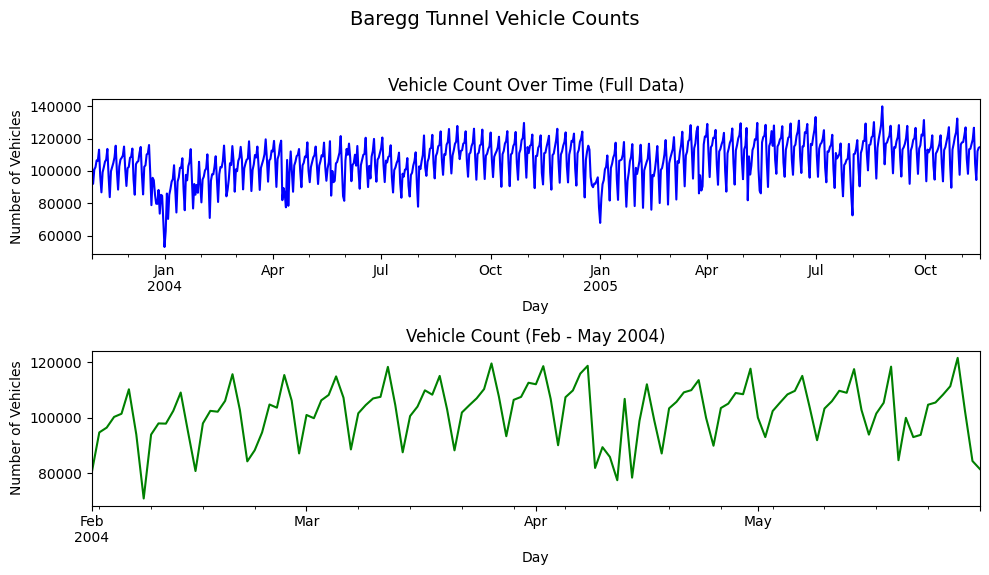

In [5]:
# Plotting if data is successfully loaded
if vehicles_ts is not None:
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

    # Plot full dataset
    vehicles_ts.plot(ax=axes[0], color='blue')
    axes[0].set_title("Vehicle Count Over Time (Full Data)")
    axes[0].set_xlabel('Day')
    axes[0].set_ylabel('Number of Vehicles')

    # Plot data from a specific date range
    vehicles_ts['2004-02-01':'2004-05-31'].plot(ax=axes[1], color='green')
    axes[1].set_title("Vehicle Count (Feb - May 2004)")
    axes[1].set_xlabel('Day')
    axes[1].set_ylabel('Number of Vehicles')

    # Add a main title and adjust layout
    fig.suptitle('Baregg Tunnel Vehicle Counts', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

In [6]:

def load_ridership_data(file_path, date_col='Month', value_col='Ridership', date_format='%d/%m/%Y'):
    """
    Load and preprocess the Amtrak ridership data.

    Parameters:
    file_path (str): Path to the CSV file.
    date_col (str): Name of the column with date information.
    value_col (str): Name of the column with the time series values.
    date_format (str): Format of the date column for parsing.

    Returns:
    pd.Series: Time series with DatetimeIndex and inferred frequency.
    """
    try:
        # Load the data
        df = pd.read_csv(file_path)

        # Convert date column to datetime format
        df['Date'] = pd.to_datetime(df[date_col], format=date_format)

        # Set 'Date' as index and create a time series
        ts = pd.Series(df[value_col].values, index=pd.DatetimeIndex(df['Date'], freq=pd.infer_freq(df['Date'])), name=value_col)

        print(f"Data successfully loaded with inferred frequency: {ts.index.freq}")
        return ts
    except FileNotFoundError:
        print("Error: The specified file was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None



In [7]:
ridership_ts = load_ridership_data(my_drive_path + 'Amtrak.csv')


Data successfully loaded with inferred frequency: <MonthBegin>


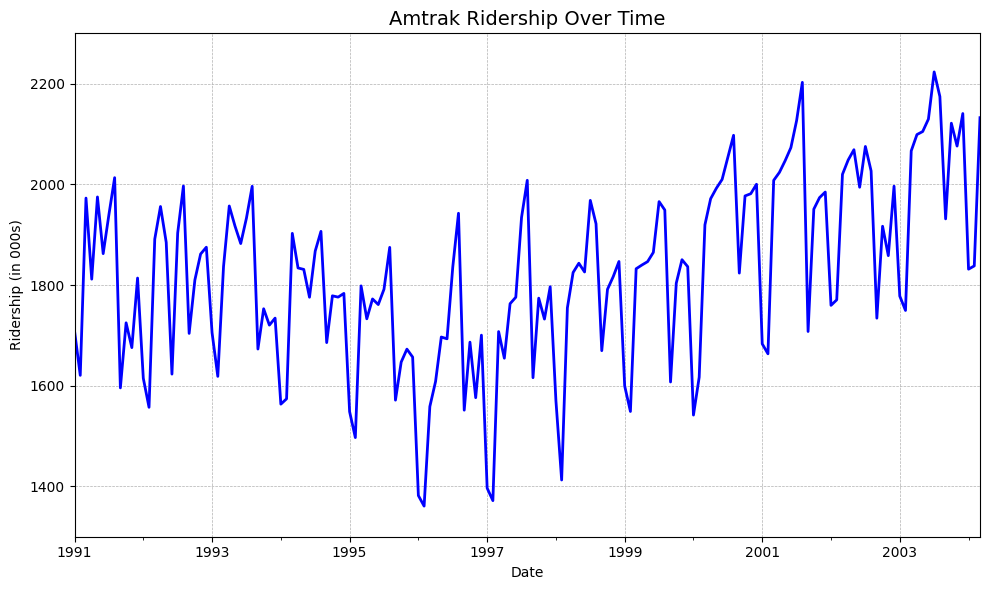

In [8]:
def plot_time_series(series, title="Time Series Plot", xlabel="Time", ylabel="Values", ylim=None):
    """
    Plot a time series with custom labels and optional y-axis limits.

    Parameters:
    series (pd.Series): The time series data to plot.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    ylim (tuple, optional): Limits for the y-axis (min, max).
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the time series data
    series.plot(ax=ax, color="blue", linewidth=2)

    # Set labels and title
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Apply y-axis limits if provided
    if ylim:
        ax.set_ylim(ylim)

    # Style and show the plot
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Plot the Amtrak Ridership data with custom settings
plot_time_series(
    ridership_ts,
    title="Amtrak Ridership Over Time",
    xlabel="Date",
    ylabel="Ridership (in 000s)",
    ylim=(1300, 2300)
)


In [9]:
ridership_ts

,Ridership
Date,
1991-01-01,1708.917
1991-02-01,1620.586
1991-03-01,1972.715
1991-04-01,1811.665
1991-05-01,1974.964
...,...
2003-11-01,2076.054
2003-12-01,2140.677
2004-01-01,1831.508


## Enhance different components in the time-series: Zoom in or plot a quadratic trendline

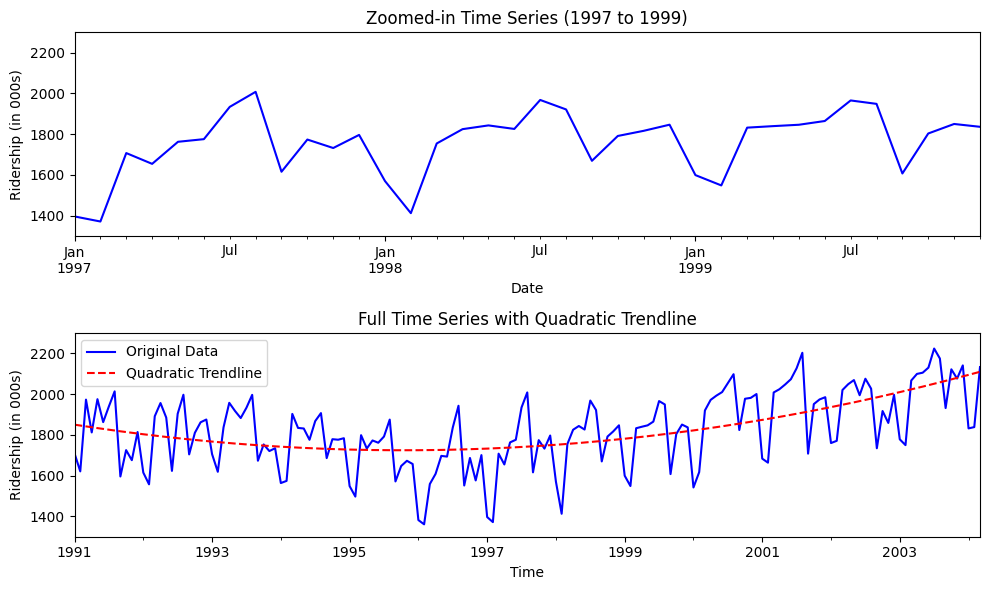

In [10]:
## MORE ORGANIZED WAY - -

def add_trend_features(series, trend_type='ctt'):
    """
    Adds constant, trend, and trend-squared terms to the DataFrame.

    Parameters:
    series (pd.Series): The time series data.
    trend_type (str): Type of trend to add ('c' for constant, 't' for linear trend, 'ct' for constant and trend,
                      'ctt' for constant, trend, and trend-squared).

    Returns:
    pd.DataFrame: DataFrame with original series and added trend features.
    """
    return tsatools.add_trend(series, trend=trend_type)

def fit_quadratic_trend(df, target='Ridership'):
    """
    Fits a quadratic trend line to the data using OLS regression.

    Parameters:
    df (pd.DataFrame): DataFrame containing the time series and trend features.
    target (str): The name of the target variable for the regression.

    Returns:
    statsmodels regression model: Fitted OLS model.
    """
    formula = f'{target} ~ trend + trend_squared'
    model = sm.OLS.from_formula(formula, data=df).fit()
    return model

def plot_with_trend(series, model, slice_range=('1997', '1999'), ylim=(1300, 2300)):
    """
    Plots the original time series and fitted trend line for a full and a zoomed-in view.

    Parameters:
    series (pd.Series): Original time series.
    model (statsmodels regression model): Fitted OLS model.
    slice_range (tuple): Date range for zoomed-in view (start, end).
    ylim (tuple): Y-axis limits for the plot.
    """
    # Slice the series for the zoomed-in view
    series_zoomed = series[slice_range[0]:slice_range[1]]

    # Prepare the full DataFrame with predicted values
    full_df = add_trend_features(series, trend_type='ctt')
    predictions = model.predict(full_df)

    # Plotting
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

    # Zoomed-in view
    series_zoomed.plot(ax=axes[0], color='blue', label="Original Data")
    axes[0].set_title(f"Zoomed-in Time Series ({slice_range[0]} to {slice_range[1]})")
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[0].set_ylim(ylim)

    # Full time series with trend
    series.plot(ax=axes[1], color='blue', label="Original Data")
    predictions.plot(ax=axes[1], color='red', linestyle='--', label="Quadratic Trendline")
    axes[1].set_title("Full Time Series with Quadratic Trendline")
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylim(ylim)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Preparing data
ridership_df = add_trend_features(ridership_ts, trend_type='ctt')  # Add trend features
ridership_lm = fit_quadratic_trend(ridership_df)  # Fit the trend model

# Plot the time series with trend line
plot_with_trend(ridership_ts, ridership_lm, slice_range=('1997', '1999'), ylim=(1300, 2300))


## Naive and Seasonal Naive Forecast for 3 years (2001 to 2004)

### Create the functions you plan to use

In [11]:
def partition_data(series, n_valid):
    """
    Partition the series into training and validation sets.

    Parameters:
    series (pd.Series): Time series data.
    n_valid (int): Number of observations in the validation set.

    Returns:
    pd.Series, pd.Series: Training and validation sets.
    """
    n_train = len(series) - n_valid
    train_ts = series[:n_train]
    valid_ts = series[n_train:]
    return train_ts, valid_ts

In [12]:
def generate_naive_forecast(train_series, valid_series):
    """
    Generate a naive forecast, using the last observed value in the training set.

    Parameters:
    train_series (pd.Series): Training data.
    valid_series (pd.Series): Validation data.

    Returns:
    pd.Series: Naive forecast series.
    """
    # Use .iloc[-1] to access the last element by position explicitly
    return pd.Series(train_series.iloc[-1], index=valid_series.index)


In [13]:
def generate_seasonal_naive_forecast(train_series, valid_series, season_length=12):
    """
    Generate a seasonal naive forecast, using the last season's values.

    Parameters:
    train_series (pd.Series): Training data.
    valid_series (pd.Series): Validation data.
    season_length (int): Length of the season (e.g., 12 for monthly data with yearly seasonality).

    Returns:
    pd.Series: Seasonal naive forecast series.
    """
    last_season = train_series[-season_length:]
    seasonal_repeats = pd.concat([last_season] * (len(valid_series) // season_length + 1))
    return pd.Series(seasonal_repeats[:len(valid_series)].values, index=valid_series.index)


In [14]:
def plot_forecasts(train_series, valid_series, naive_pred, seasonal_pred, title="Naive and Seasonal Naive Forecast"):
    """
    Plot the actual series with the naive and seasonal naive forecasts.

    Parameters:
    train_series (pd.Series): Training data.
    valid_series (pd.Series): Validation data.
    naive_pred (pd.Series): Naive forecast series.
    seasonal_pred (pd.Series): Seasonal naive forecast series.
    title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training and validation sets
    train_series.plot(ax=ax, color='C0', linewidth=0.75, label="Training")
    valid_series.plot(ax=ax, color='C0', linestyle='dashed', linewidth=0.75, label="Validation")

    # Plot forecasts
    naive_pred.plot(ax=ax, color='green', linestyle='-', label="Naive Forecast")
    seasonal_pred.plot(ax=ax, color='orange', linestyle='-', label="Seasonal Naive Forecast")

    # Set plot labels, limits, and title
    ax.set_xlim('1990', '2006-6')
    ax.set_ylim(1300, 2600)
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')
    ax.set_title(title)
    ax.legend()

    # Annotate sections
    ax.axvline(x=train_series.index[-1], color='black', linewidth=0.5, linestyle='--', label="Partition Point")
    ax.text(train_series.index[int(len(train_series)*0.5)], 2500, 'Training', ha='center')
    ax.text(valid_series.index[int(len(valid_series)*0.5)], 2500, 'Validation', ha='center')

    plt.tight_layout()
    plt.show()

### Call the functions

In [15]:
n_valid = 36

# Partition data
train_ts, valid_ts = partition_data(ridership_ts, n_valid)


# Generate forecasts
naive_pred = generate_naive_forecast(train_ts, valid_ts)

seasonal_pred = generate_seasonal_naive_forecast(train_ts, valid_ts)

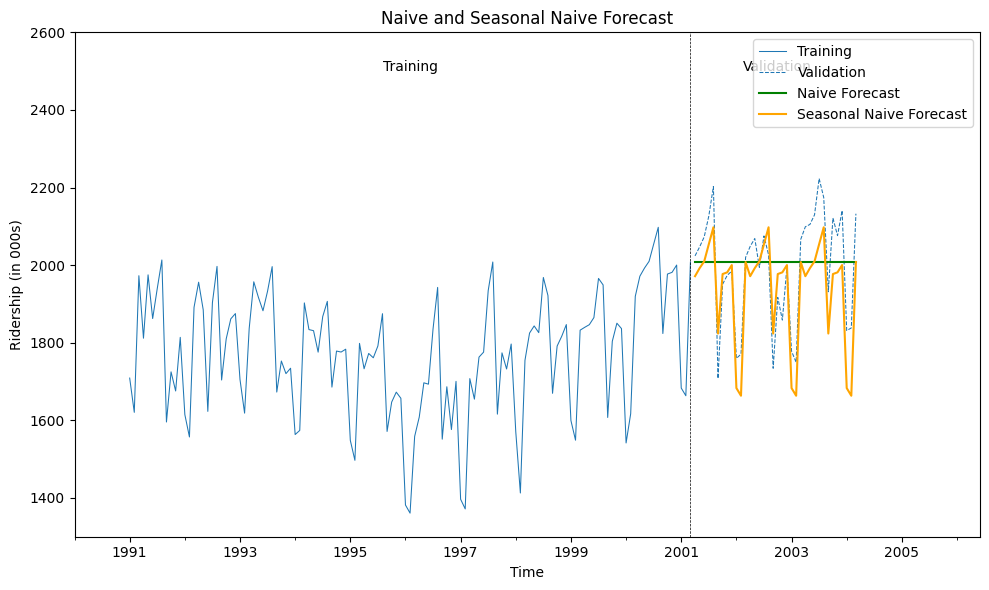

In [16]:
# Plot forecasts and actuals
plot_forecasts(train_ts, valid_ts, naive_pred, seasonal_pred)

## Predictive Accuracy of Naive and Seasonal Naive

In [17]:
def calculate_predictive_accuracy(actual, predicted, model_name="Model"):
    """
    Calculate and display predictive accuracy using regressionSummary.

    Parameters:
    actual (pd.Series): The actual values.
    predicted (pd.Series): The forecasted values.
    model_name (str): Name of the model for labeling output.
    """
    print(f"\nPredictive Accuracy for {model_name}")
    regressionSummary(actual, predicted)

In [18]:
def train_model_accuracy(train_series, model_type="naive"):
    """
    Calculate predictive accuracy on the training set for naive or seasonal naive model.

    Parameters:
    train_series (pd.Series): Training time series data.
    model_type (str): Model type, either 'naive' or 'seasonal'.
    """
    if model_type == "naive":
        naive_train_ts = pd.Series(train_series[:-1].values, index=train_series[1:].index)
        print("\nNaive model in training set:")
        regressionSummary(train_series[1:], naive_train_ts)
        return naive_train_ts
    elif model_type == "seasonal":
        seasonal_train_ts = pd.Series(train_series[:-12].values, index=train_series[12:].index)
        print("\nSeasonal model in training set:")
        regressionSummary(train_series[12:], seasonal_train_ts)
        return seasonal_train_ts
    else:
        print("Invalid model type. Choose 'naive' or 'seasonal'.")


In [19]:
def plot_training_forecast(train_series, naive_train_ts, seasonal_train_ts):
    """
    Plot the training time series with naive and seasonal naive forecasts.

    Parameters:
    train_series (pd.Series): Training time series data.
    naive_train_ts (pd.Series): Naive forecast for the training set.
    seasonal_train_ts (pd.Series): Seasonal naive forecast for the training set.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    train_series.plot(ax=ax, color='blue', label="Training Series")
    naive_train_ts.plot(ax=ax, color='green', linestyle='--', label="Naive Forecast")
    seasonal_train_ts.plot(ax=ax, color='orange', linestyle='--', label="Seasonal Naive Forecast")

    ax.set_title("Training Series with Naive and Seasonal Naive Forecasts")
    ax.set_xlabel("Time")
    ax.set_ylabel("Ridership (in 000s)")
    ax.legend()
    plt.tight_layout()
    plt.show()

### Assess Accuracy


Predictive Accuracy for Naive Forecast (Validation Set)

Regression statistics

                      Mean Error (ME) : -14.7177
       Root Mean Squared Error (RMSE) : 142.7551
            Mean Absolute Error (MAE) : 115.9234
          Mean Percentage Error (MPE) : -1.2750
Mean Absolute Percentage Error (MAPE) : 6.0214

Predictive Accuracy for Seasonal Naive Forecast (Validation Set)

Regression statistics

                      Mean Error (ME) : 54.7296
       Root Mean Squared Error (RMSE) : 95.6243
            Mean Absolute Error (MAE) : 84.0941
          Mean Percentage Error (MPE) : 2.6528
Mean Absolute Percentage Error (MAPE) : 4.2477

Naive model in training set:

Regression statistics

                      Mean Error (ME) : 2.4509
       Root Mean Squared Error (RMSE) : 168.1470
            Mean Absolute Error (MAE) : 125.2975
          Mean Percentage Error (MPE) : -0.3460
Mean Absolute Percentage Error (MAPE) : 7.2714

Seasonal model in training set:

Regression statistics

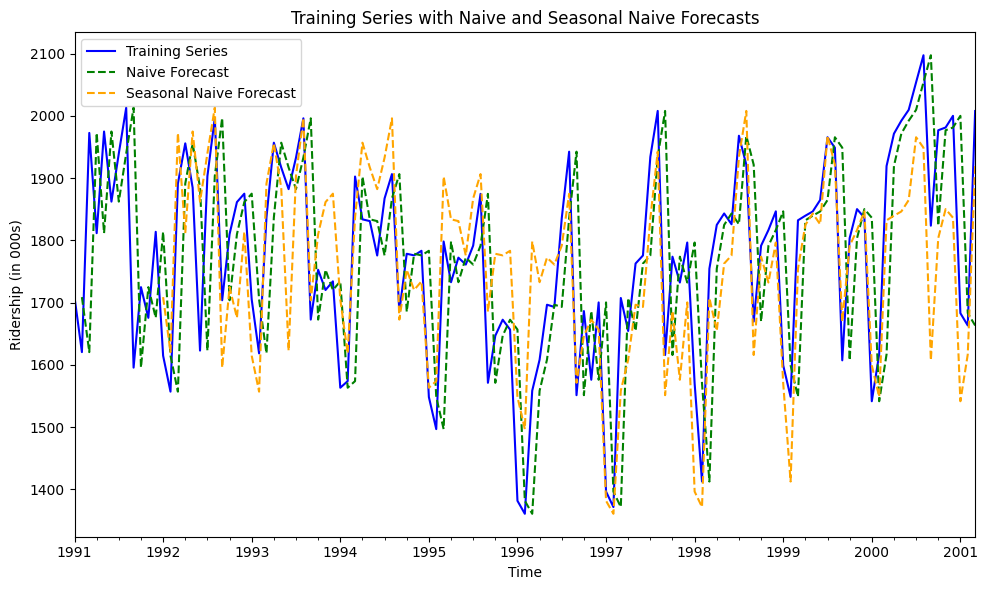

In [20]:
# Calculate predictive accuracy for validation set
calculate_predictive_accuracy(valid_ts, naive_pred, model_name="Naive Forecast (Validation Set)")
calculate_predictive_accuracy(valid_ts, seasonal_pred, model_name="Seasonal Naive Forecast (Validation Set)")

# Calculate predictive accuracy for training set and obtain forecasts
naive_train_ts = train_model_accuracy(train_ts, model_type="naive")
seasonal_train_ts = train_model_accuracy(train_ts, model_type="seasonal")

# Plot training series with naive and seasonal naive forecasts
plot_training_forecast(train_ts, naive_train_ts, seasonal_train_ts)

## Decomposing Time Series

In [21]:
# Perform additive and multiplicative decomposition
additive_decomp = seasonal_decompose(ridership_ts, model='additive')
multiplicative_decomp = seasonal_decompose(ridership_ts, model='multiplicative')

# Create subplots for additive and multiplicative decomposition
fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=[
        "Additive - Observed", "Multiplicative - Observed",
        "Additive - Trend", "Multiplicative - Trend",
        "Additive - Seasonal", "Multiplicative - Seasonal",
        "Additive - Residual", "Multiplicative - Residual"
    ],
    shared_xaxes=True,
    vertical_spacing=0.05
)

# Plot each component for the additive model
fig.add_trace(go.Scatter(x=additive_decomp.observed.index, y=additive_decomp.observed, name="Observed (Additive)", line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=additive_decomp.trend.index, y=additive_decomp.trend, name="Trend (Additive)", line=dict(color='green')), row=2, col=1)
fig.add_trace(go.Scatter(x=additive_decomp.seasonal.index, y=additive_decomp.seasonal, name="Seasonal (Additive)", line=dict(color='orange')), row=3, col=1)
fig.add_trace(go.Scatter(x=additive_decomp.resid.index, y=additive_decomp.resid, name="Residual (Additive)", line=dict(color='red')), row=4, col=1)

# Plot each component for the multiplicative model
fig.add_trace(go.Scatter(x=multiplicative_decomp.observed.index, y=multiplicative_decomp.observed, name="Observed (Multiplicative)", line=dict(color='blue')), row=1, col=2)
fig.add_trace(go.Scatter(x=multiplicative_decomp.trend.index, y=multiplicative_decomp.trend, name="Trend (Multiplicative)", line=dict(color='green')), row=2, col=2)
fig.add_trace(go.Scatter(x=multiplicative_decomp.seasonal.index, y=multiplicative_decomp.seasonal, name="Seasonal (Multiplicative)", line=dict(color='orange')), row=3, col=2)
fig.add_trace(go.Scatter(x=multiplicative_decomp.resid.index, y=multiplicative_decomp.resid, name="Residual (Multiplicative)", line=dict(color='red')), row=4, col=2)

# Update layout
fig.update_layout(
    title="Additive vs Multiplicative Decomposition of Ridership Time Series",
    height=800,
    showlegend=False,
    template="plotly_white"
)

# Add axis labels
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Residual", row=4, col=1)
fig.update_yaxes(title_text="Observed", row=1, col=2)
fig.update_yaxes(title_text="Trend", row=2, col=2)
fig.update_yaxes(title_text="Seasonal", row=3, col=2)
fig.update_yaxes(title_text="Residual", row=4, col=2)
fig.update_xaxes(title_text="Time", row=4, col=1)
fig.update_xaxes(title_text="Time", row=4, col=2)

# Show the plot
fig.show()

# Problem 16.6: Souvenir Sales
The file _SouvenirSales.csv_ contains monthly sales for a souvenir shop at a beach resort town in Queensland, Australia, between 1995--2001. (Source: Hyndman, R.J., Time Series Data Library, https://datamarket.com/data/list/?q=provider:tsdl. Accessed on 11/20/2018.)

Back in 2001, the store wanted to use the data to forecast sales for the next 12 months (year 2002). They hired an analyst to generate forecasts. The analyst first partitioned the data into training and validation sets, with the validation set containing the last 12 months of data (year 2001). She then fit a regression model to sales, using the training set.

## Solution 16.6.a
Create a well-formatted time plot of the data.

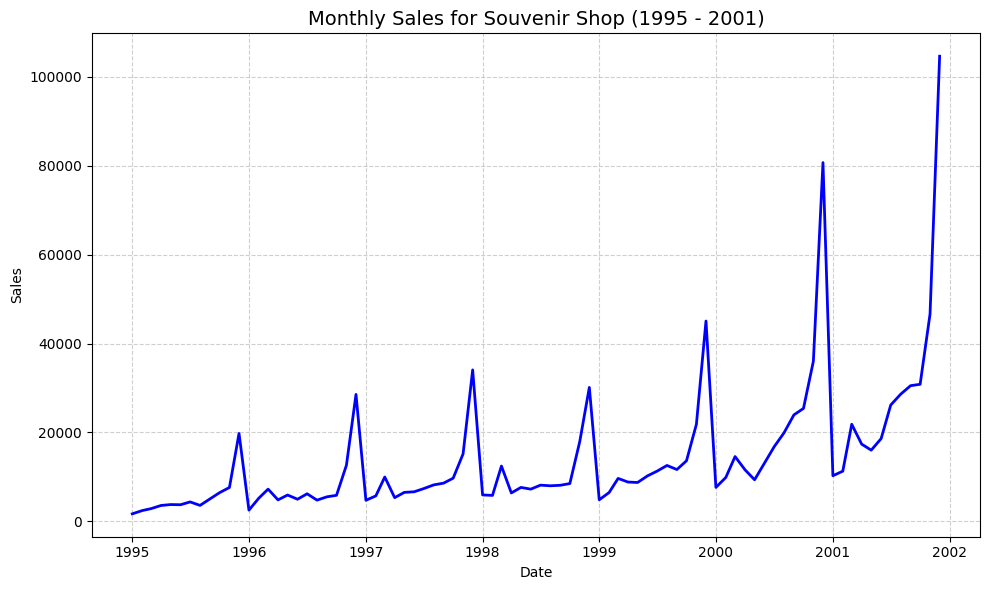

In [22]:
souvenir_data = pd.read_csv(my_drive_path + 'SouvenirSales.csv')

# Convert date column to datetime format
souvenir_data['Date'] = pd.to_datetime(souvenir_data['Date'], format='%b-%y')
souvenir_data.set_index('Date', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(souvenir_data.index, souvenir_data['Sales'], color='blue', linewidth=2)
plt.title("Monthly Sales for Souvenir Shop (1995 - 2001)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Solution 16.6.b
Change the scale on the `x`-axis, or on the `y`-axis, or on both to log-scale in order to achieve a linear relationship. Select the time plot that seems most linear.

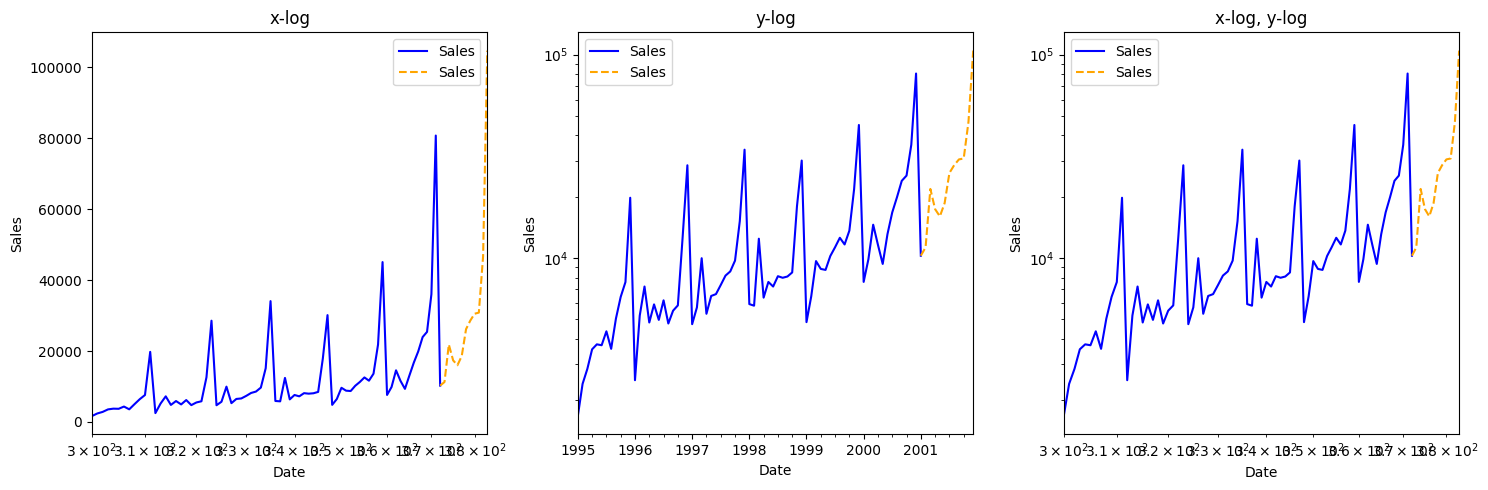

In [23]:
# Partition data into training and validation sets
train_ts = souvenir_data[:'2001-01-01']
valid_ts = souvenir_data['2001-01-01':]

# Create a function to plot with different scales
def plot_with_log_scales(train_series, valid_series):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Plot with x-log scale
    ax = train_series.plot(ax=axes[0], color='blue', label='Training', title='x-log')
    valid_series.plot(ax=ax, color='orange', linestyle='--', label='Validation')
    ax.set_xscale('log')
    ax.set_ylabel('Sales')
    ax.legend()

    # Plot with y-log scale
    ax = train_series.plot(ax=axes[1], color='blue', label='Training', title='y-log')
    valid_series.plot(ax=ax, color='orange', linestyle='--', label='Validation')
    ax.set_yscale('log')
    ax.set_ylabel('Sales')
    ax.legend()

    # Plot with both x-log and y-log scales
    ax = train_series.plot(ax=axes[2], color='blue', label='Training', title='x-log, y-log')
    valid_series.plot(ax=ax, color='orange', linestyle='--', label='Validation')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Sales')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot with different log scales
plot_with_log_scales(train_ts, valid_ts)

Plotting log on the y-axis produces the most linear plot.

## Solution 16.6.c
Comparing the two time plots, what can be said about the type of trend in the data?

Since the log plot comes out linear, we can conclude that the actual trend in
the data is exponential.

## Solution 16.6.d
Why were the data partitioned? Partition the data into the training and validation set as explained above.

The validation partition provides a benchmark against which to test
predictions, which is important because the goal of this effort is to forecast
future sales.

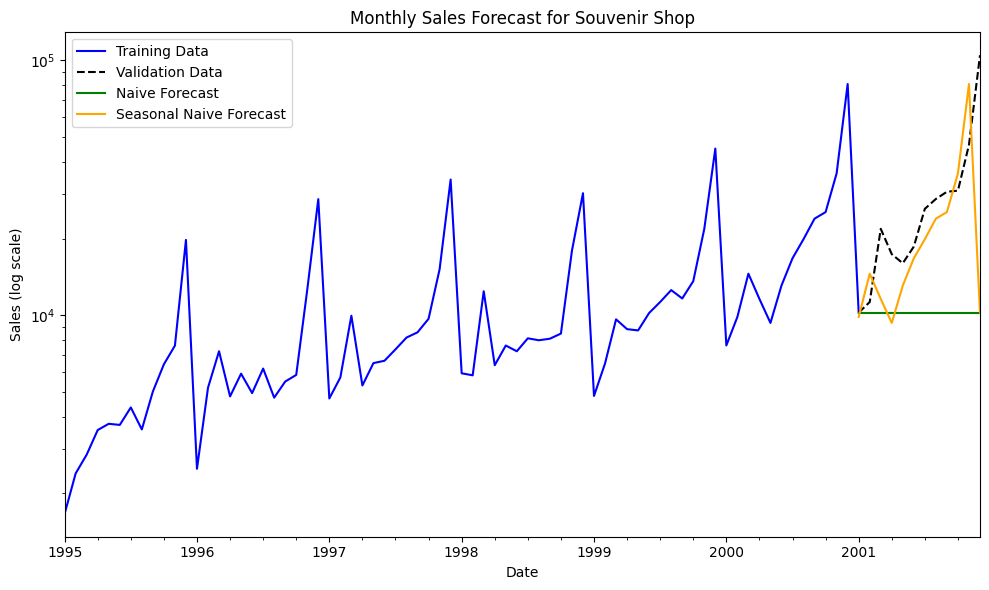

In [ ]:
# Function to generate a naive forecast
def generate_naive_forecast(train_series, valid_index):
    """
    Generate a naive forecast by repeating the last observed value in the training set.

    Parameters:
    train_series (pd.Series): Training data.
    valid_index (pd.Index): Index for the validation period.

    Returns:
    pd.Series: Naive forecast series.
    """
    return pd.Series(train_series.iloc[-1], index=valid_index)

# Function to generate a seasonal naive forecast
def generate_seasonal_naive_forecast(train_series, valid_index, season_length=12):
    """
    Generate a seasonal naive forecast by repeating the last season's values.

    Parameters:
    train_series (pd.Series): Training data.
    valid_index (pd.Index): Index for the validation period.
    season_length (int): Length of the season (default is 12 for monthly data).

    Returns:
    pd.Series: Seasonal naive forecast series.
    """
    last_season = train_series[-season_length:]
    # Repeat only the values of the last season
    repeated_season = pd.Series(
        (list(last_season.values) * (len(valid_index) // season_length + 1))[:len(valid_index)],
        index=valid_index
    )
    return repeated_season

# Generate forecasts
naive_pred = generate_naive_forecast(train_ts['Sales'], valid_ts.index)
seasonal_pred = generate_seasonal_naive_forecast(train_ts['Sales'], valid_ts.index)

# Plot the training data, validation data, and forecasts
fig, ax = plt.subplots(figsize=(10, 6))
train_ts['Sales'].plot(ax=ax, color='blue', label='Training Data')
valid_ts['Sales'].plot(ax=ax, color='black', linestyle='--', label='Validation Data')
naive_pred.plot(ax=ax, color='green', linestyle='-', label='Naive Forecast')
seasonal_pred.plot(ax=ax, color='orange', linestyle='-', label='Seasonal Naive Forecast')

# Set log scale, labels, and title
ax.set_yscale('log')
ax.set_xlabel('Date')
ax.set_ylabel('Sales (log scale)')
ax.set_title('Monthly Sales Forecast for Souvenir Shop')
ax.legend()
plt.tight_layout()
plt.show()